In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Load the Desired Trained Network


In [2]:
# load the dataset and model in question and generate the statistics 
from keras.models import model_from_json

ModelName = 'Unet_trained_with_classWeights' # change this for saving files properly
FileNameJson = '/content/drive/MyDrive/CS 738/Project/My Trained Models/Unet_trained_withoutClassweights.json'
FileNameh5 = '/content/drive/MyDrive/CS 738/Project/My Trained Models/Unet_trained_withoutClassWeights_MW.h5'


json_file = open(FileNameJson, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(FileNameh5)
model.compile()
print("Loaded model from disk and compiled")


Loaded model from disk and compiled


Load the Data to Be Tested on the Trained Model

In [3]:
Xtest = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data/XtestDataResized/Xdata_10_resized.npy')
Ytest = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data/YtestDataResized/Ylabels_10_resized.npy')

##Make Predictions on the Given Dataset and Get Stats

Computing Rand Error and Structural Similiarity Index

In [ ]:
from skimage.metrics import adapted_rand_error
from skimage.metrics import structural_similarity
from sklearn.metrics import mean_squared_error
from sklearn.metrics import normalized_mutual_info_score

#Total Error
AverageRandError = 0
AverageSSI = 0
AverageMSE = 0
AverageNMI = 0
#variance
VarSSI = []
VarRand = []
VarMSE = []
VarNMI = []


Yhat_storage = np.zeros(Ytest.shape) #initialize Yhat 
Ytrue_storage = np.zeros(Ytest.shape)

for k in range(0, Xtest.shape[0]): # iterate through the test set

  sample_point = Xtest[k,:,:,:]
  sample_label = Ytest[k,:,:,:]
  sample_label = sample_label.astype(int)

  sample_point = sample_point[tf.newaxis,...]
  Yhat = model.predict(sample_point) # make the prediction on the image
  
  #convert to proper mask labels for relevant stats
  Yhat = Yhat.reshape((128,128,4))
  Yhat = tf.argmax(Yhat, axis=-1)
  Yhat = Yhat[..., tf.newaxis]
  Yhat = Yhat.numpy() # convert to numpy to use skimage rand module

  #store Yhat for computing pixel by pixel statistics
  Yhat_storage[k,:,:,:] = Yhat
  Ytrue_storage[k,:,:,:] = sample_label # store true labels here in proper format for easier stat generation

  #include class 0 in the statistics (skimage module automatically ignores class 0 by default)
  sample_label += 1
  Yhat += 1

  #Rand Error
  Error = adapted_rand_error(sample_label, Yhat)
  AverageRandError += Error[0]
  VarRand.append(Error)

  #SSI
  ssi = structural_similarity(sample_label, Yhat, multichannel=True, data_range=4, gaussian_weights = True)
  AverageSSI += ssi
  VarSSI.append(ssi)

  #MSE 
  mse = mean_squared_error(np.ravel(sample_label), np.ravel(Yhat))
  AverageMSE += mse
  VarMSE.append(mse)

  #Normalized Mutual Information
  nmi = normalized_mutual_info_score(np.ravel(sample_label), np.ravel(Yhat))
  AverageNMI += nmi
  VarNMI.append(nmi)


AverageRandError = AverageRandError / Xtest.shape[0]
VarRand = np.var(VarRand)
print('The Average Adapted Rand Error is:', AverageRandError)
print('Variance of Adapted Rand Error is:', VarRand)

AverageSSI = AverageSSI / Xtest.shape[0]
VarSSI = np.var(VarSSI)
print('The Average SSI is:', AverageSSI)
print('Variance of SSI is:', VarSSI)

AverageMSE = AverageMSE / Xtest.shape[0]
VarMSE = np.var(VarMSE)
print('The Average MSE is:', AverageMSE)
print('Variance of MSE is:', VarMSE)

AverageNMI = AverageNMI / Xtest.shape[0]
VarNMI = np.var(VarNMI)
print('The Average NMI is:', AverageNMI)
print('Variance of NMI is:', VarNMI)


The Average Adapted Rand Error is: 0.1169472139471361
Variance of Adapted Rand Error is: 0.14417805490944247
The Average SSI is: 0.6536110483291075
Variance of SSI is: 0.03323252869344721
The Average MSE is: 0.4963548677461641
Variance of MSE is: 0.2861673996401874
The Average NMI is: 0.6516681997660584
Variance of NMI is: 0.04364393630076896


## Compute Pure Pixel Error and Statistics on Pixel by Pixel Basis 

In [ ]:
## classification report
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn


#vectorize image data 
Yhat_vector = np.ravel(Yhat_storage)
Ytrue_vector = np.ravel(Ytrue_storage)

report_dict = classification_report(Ytrue_vector, Yhat_vector, output_dict=True)

#add in the rand,SSI, MSE and NMI measurements
report_dict['Average Rand Error'] = AverageRandError
report_dict['Rand Error Variance'] = VarRand
report_dict['Average SSI'] = AverageSSI
report_dict['SSI Variance'] = VarSSI
report_dict['Average MSE'] = AverageMSE
report_dict['MSE Variance'] = VarMSE
report_dict['Average NMI'] = AverageNMI
report_dict['NMI Variance'] = VarNMI


reportDF = pd.DataFrame(report_dict)
CVStatsFileName = '/content/drive/MyDrive/CS 738/Project/Statistics_MyModels/' + ModelName + '.csv'
reportDF.to_csv(CVStatsFileName)  # save the test results##

# generate confusion matrix
CM = confusion_matrix(Ytrue_vector, Yhat_vector)
df_cm = pd.DataFrame(CM, index=[i for i in np.unique(Ytrue_vector)],
                         columns=[i for i in np.unique(Ytrue_vector)])

#generate figures and save statistics in csv files
plt.figure(figsize=(12, 9))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
CMatrixFileN = '/content/drive/MyDrive/CS 738/Project/Statistics_MyModels/' + ModelName + '.png'
plt.savefig(CMatrixFileN, format='png')  # save as png
plt.close('all')


For Visualizing Some Outputs for Report

In [4]:
from skimage.metrics import adapted_rand_error
from skimage.metrics import structural_similarity
from sklearn.metrics import mean_squared_error
from sklearn.metrics import normalized_mutual_info_score

def display(display_list):
  fig = plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow((display_list[i]), vmin=0, vmax=3)
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):

  pred_mask = np.reshape(pred_mask, (128,128,4))
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask


def show_predictions(X,Y, num=0):

  PrintErrors(Y,X,num)

  x = X[num,:,:,:]
  pred_mask = model.predict(x[tf.newaxis,...])
  pred_mask = create_mask(pred_mask)
  
  display([X[num,:,:,:],Y[num,:,:,0], pred_mask[:,:,0]])
  

def PrintErrors(Ytest, Xtest, k):

  sample_point = Xtest[k,:,:,:]
  sample_label = Ytest[k,:,:,:]
  sample_label = sample_label.astype(int)

  sample_point = sample_point[tf.newaxis,...]
  Yhat = model.predict(sample_point) # make the prediction on the image
  
  #convert to proper mask labels for relevant stats
  Yhat = Yhat.reshape((128,128,4))
  Yhat = tf.argmax(Yhat, axis=-1)
  Yhat = Yhat[..., tf.newaxis]
  Yhat = Yhat.numpy() # convert to numpy to use skimage rand module

  Ytrue = sample_label

  Error = adapted_rand_error(Ytrue, Yhat)
  print('Adapted Rand Error:', Error[0], '\n')
  Error = structural_similarity(Ytrue, Yhat, multichannel=True, data_range=4, gaussian_weights = True)
  print('SSI:', Error, '\n')
  Error = mean_squared_error(np.ravel(Ytrue), np.ravel(Yhat))
  print('Mean Squared Error:', Error, '\n')
  Error = normalized_mutual_info_score(np.ravel(Ytrue), np.ravel(Yhat))
  print('Normalized Mutual Information:', Error, '\n')
  Error = np.sum(Ytrue != Yhat) / (Yhat.shape[0] * Yhat.shape[1])
  print('Pixel Error:', Error, '\n')

663

Image Number: 376
Adapted Rand Error: 0.003106620159132212 

SSI: 0.8627019547948199 

Mean Squared Error: 0.19354248046875 

Normalized Mutual Information: 0.8555629890517102 

Pixel Error: 0.029052734375 



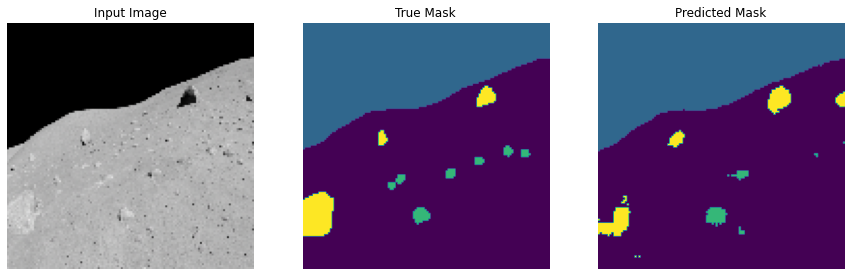

In [ ]:
index = np.random.randint(0,Xtest.shape[0])
print('Image Number:', index)
show_predictions(Xtest,Ytest, index)

Image Number: 376
Adapted Rand Error: 0.04495003392374197 

SSI: 0.8791971904039964 

Mean Squared Error: 0.27069091796875 

Normalized Mutual Information: 0.8717689432860746 

Pixel Error: 0.03680419921875 



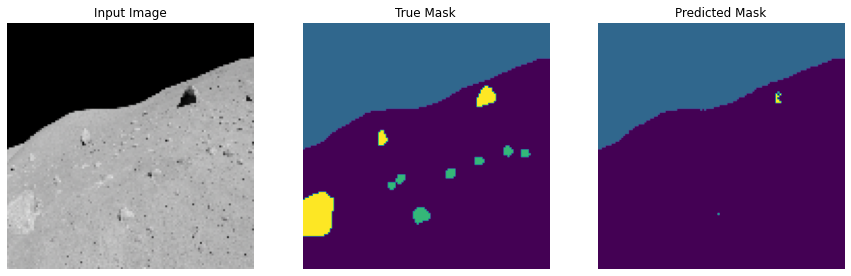

In [5]:
index = 376 #np.random.randint(0,Xtest.shape[0])
print('Image Number:', index)
show_predictions(Xtest,Ytest, index)

Image Number: 818
Adapted Rand Error: 0.006660383300863715 

SSI: 0.724441906750265 

Mean Squared Error: 0.4404296875 

Normalized Mutual Information: 0.7747594391031597 

Pixel Error: 0.0718994140625 



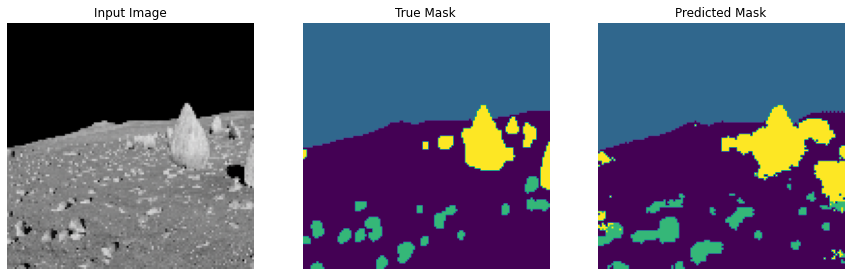

In [ ]:
index = np.random.randint(0,Xtest.shape[0])
print('Image Number:', index)
show_predictions(Xtest,Ytest, index)

Image Number: 747
Adapted Rand Error: 0.09559931019579937 

SSI: 0.4862317410945454 

Mean Squared Error: 0.921142578125 

Normalized Mutual Information: 0.537268497180473 

Pixel Error: 0.143798828125 



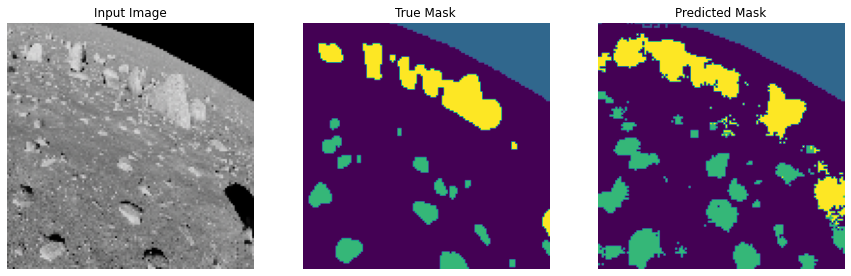

In [ ]:
index = np.random.randint(0,Xtest.shape[0])
print('Image Number:', index)
show_predictions(Xtest,Ytest, index)

Image Number: 308
Adapted Rand Error: 0.36139398925846966 

SSI: 0.6679868053095637 

Mean Squared Error: 1.0517578125 

Normalized Mutual Information: 0.49211480843068456 

Pixel Error: 0.14324951171875 



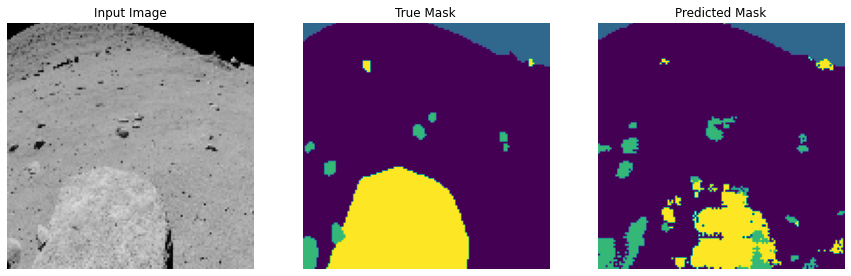

In [ ]:
index = np.random.randint(0,Xtest.shape[0])
print('Image Number:', index)
show_predictions(Xtest,Ytest, index)

With and without Class Weights

Image Number: 474
Adapted Rand Error: 0.03107700392313195 

SSI: 0.8631964264577972 

Mean Squared Error: 0.1689453125 

Normalized Mutual Information: 0.806186497872525 

Pixel Error: 0.03009033203125 



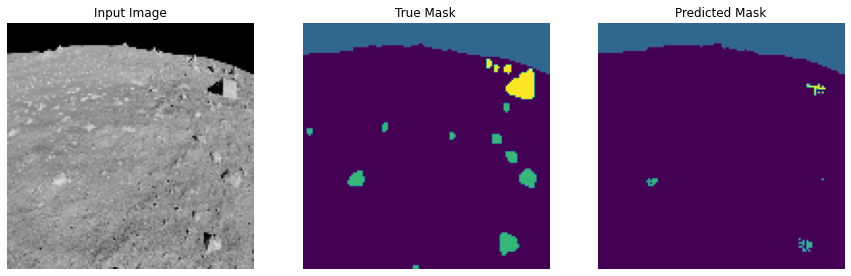

In [ ]:
index = 474
print('Image Number:', index)
show_predictions(Xtest,Ytest, index)